# Consolidated Pre-processing Notebook

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import cross_validate
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, RandomizedSearchCV


In [2]:
#Load dataset from ../raw_data/
df = pd.read_csv("../raw_data/chicago.csv")
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 257077 entries, 0 to 257076
Data columns (total 17 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   CASE#                   257077 non-null  object 
 1   DATE  OF OCCURRENCE     257077 non-null  object 
 2   BLOCK                   257077 non-null  object 
 3    IUCR                   257077 non-null  object 
 4    PRIMARY DESCRIPTION    257077 non-null  object 
 5    SECONDARY DESCRIPTION  257077 non-null  object 
 6    LOCATION DESCRIPTION   256032 non-null  object 
 7   ARREST                  257077 non-null  object 
 8   DOMESTIC                257077 non-null  object 
 9   BEAT                    257077 non-null  int64  
 10  WARD                    257077 non-null  int64  
 11  FBI CD                  257077 non-null  object 
 12  X COORDINATE            257011 non-null  float64
 13  Y COORDINATE            257011 non-null  float64
 14  LATITUDE            

In [3]:
df.head(3)

,CASE#,DATE OF OCCURRENCE,BLOCK,IUCR,PRIMARY DESCRIPTION,SECONDARY DESCRIPTION,LOCATION DESCRIPTION,ARREST,DOMESTIC,BEAT,WARD,FBI CD,X COORDINATE,Y COORDINATE,LATITUDE,LONGITUDE,LOCATION
0,JH117298,01/16/2024 01:00:00 AM,038XX W DIVERSEY AVE,0810,THEFT,OVER $500,STREET,N,N,2524,35,06,1150337.0,1918345.0,41.931844,-87.722951,"(41.931843966, -87.722950868)"
1,JG561057,12/31/2023 04:30:00 PM,004XX N WABASH AVE,0460,BATTERY,SIMPLE,STREET,N,N,1834,42,08B,1176592.0,1902931.0,41.888994,-87.626935,"(41.888993854, -87.626934833)"
2,JH117691,01/16/2024 06:50:00 PM,010XX W 99TH ST,143A,WEAPONS VIOLATION,UNLAWFUL POSSESSION - HANDGUN,STREET,Y,N,2232,21,15,1170976.0,1839080.0,41.713905,-87.649425,"(41.713904887, -87.649424515)"


Raw datset columns has typographical errors. Below code resolves this:

In [4]:
# Remove leading and trailing spaces from each column name
df.columns = df.columns.str.strip()

# Apply strip() to each column where the data type is string (object)
df = df.applymap(lambda x: x.strip() if isinstance(x, str) else x)

# If the column name has multiple spaces (e.g., "DATE  OF OCCURRENCE"), replace them
df.columns = df.columns.str.replace('  ', ' ', regex=False)

/tmp/ipykernel_111641/2776783813.py:5: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df = df.applymap(lambda x: x.strip() if isinstance(x, str) else x)


Drop na values in location coordinates (total 66 rows): 

In [5]:
# Remove rows where any of the specified columns have missing data
df = df.dropna(subset=['X COORDINATE', 'Y COORDINATE', 'LATITUDE', 'LONGITUDE', 'LOCATION'])

Feature Engineer the following features: 
1. Time of Day (Early Morning, etc.), per 4h increment
2. Weekend? (i.e. Friday 5pm onwards to Sunday 11:59pm)
3. Month

In [6]:
# Convert 'DATE OF OCCURRENCE' to datetime format
df['DATE OF OCCURRENCE'] = pd.to_datetime(df['DATE OF OCCURRENCE'], errors='coerce')

# Create a function to categorize time into buckets
def categorize_time(hour):
    if 0 <= hour < 6:
        return "Late Evening"
    elif 6 <= hour < 9:
        return "Early Morning"
    elif 9 <= hour < 12:
        return "Late Morning"
    elif 12 <= hour < 15:
        return "Early Noon"
    elif 15 <= hour < 18:
        return "Late Noon"
    else:
        return "Early Evening"

# Apply the time categorization to create 'TIME OF DAY' column
df['TIME OF DAY'] = df['DATE OF OCCURRENCE'].dt.hour.map(categorize_time)

In [7]:
# Extract the month from 'DATE  OF OCCURRENCE' and create a new column 'MONTH'
df['MONTH'] = df['DATE OF OCCURRENCE'].dt.month_name()

In [8]:
df['WEEKDAY'] = df['DATE OF OCCURRENCE'].dt.strftime('%A')

In [9]:
df['WEEKDAY NUM'] = df['DATE OF OCCURRENCE'].dt.weekday

In [10]:
df['WEEKEND'] = np.where(df['WEEKDAY NUM'] <= 4, 'NO','YES')

In [11]:
df.drop(['WEEKEND'],axis=1,inplace = True)

In [12]:
# Extract day of week and hour
df['hour'] = df['DATE OF OCCURRENCE'].dt.hour
# Use conditions to determine 'Weekend'
df['WEEKEND'] = (
    (df['WEEKDAY NUM'] == 4) & (df['hour'] >= 17) |  # Friday after 5 PM
    (df['WEEKDAY NUM'].isin([5, 6]))                 # Saturday or Sunday
).map({True: '1', False: '0'})
# Drop intermediate columns if desired
df.drop(['hour'], axis=1, inplace=True)

#### Convert Month and Time of Day columns to sine/cosine

    - Ordinal Encoding: Works well if months have a natural order relevant to the problem (e.g., sales data trends over a year).
    - One-Hot Encoding: Suitable for models like logistic regression that cannot infer order from numerical values.
    - Cyclical Encoding: Best when the cyclical nature of months is important (e.g., temperature data over a year).

In [13]:
# Create a mapping for months to numbers (1-12)
month_order = {
    'January': 1, 'February': 2, 'March': 3, 'April': 4,
    'May': 5, 'June': 6, 'July': 7, 'August': 8,
    'September': 9, 'October': 10, 'November': 11, 'December': 12
}

In [14]:
df['MONTH_ENCODED'] = df['MONTH'].map(month_order)

In [15]:
# Apply sine and cosine transformations
df['MONTH_SIN'] = np.sin(2 * np.pi * df['MONTH_ENCODED'] / 12)
df['MONTH_COS'] = np.cos(2 * np.pi * df['MONTH_ENCODED'] / 12)

In [16]:
# Define an ordinal mapping for time_of_day
time_order = {
    'Early Morning': 1,
    'Late Morning': 2,
    'Early Noon': 3,
    'Late Noon': 4,
    'Early Evening': 5,
    'Late Evening': 6
}
# Apply the mapping
df['TIME ENCODED'] = df['TIME OF DAY'].map(time_order)

### Spliting THEFT into two group of data 'THEFT UNDER $500' and 'THEFT OVER $500'

In [17]:
# Filter for 'PRIMARY DESCRIPTION' = 'THEFT'
theft_data = df[df['PRIMARY DESCRIPTION'] == 'THEFT']

# Group the data by 'PRIMARY DESCRIPTION' and 'SECONDARY DESCRIPTION', then count occurrences
theft_grouped_data = theft_data.groupby(['PRIMARY DESCRIPTION', 'SECONDARY DESCRIPTION']).size().reset_index(name='Count')

# Assign the desired names dynamically
group_1_description = 'THEFT UNDER $500'
group_2_description = 'THEFT OVER $500'

#   iloc    PRIMARY DESCRIPTION                 SECONDARY DESCRIPTION   Count
#   0               THEFT                          $500 AND UNDER       19167
#   1               THEFT                           ATTEMPT THEFT         386
#   2               THEFT                DELIVERY CONTAINER THEFT          32
#   3               THEFT                           FROM BUILDING        5422
#   4               THEFT    FROM COIN-OPERATED MACHINE OR DEVICE          13
#   5               THEFT                               OVER $500       18248
#   6               THEFT                          POCKET-PICKING        1371
#   7               THEFT                         PURSE-SNATCHING         275
#   8               THEFT                            RETAIL THEFT       13432
#   9               THEFT                THEFT FROM MOTOR VEHICLE        1748

# Split the data into Group 1 and Group 2 based on manual grouping (row indices)
group_1 = theft_grouped_data.iloc[[0, 1, 2, 3, 4, 6, 7, 9]]  # Rows for Group 1
group_2 = theft_grouped_data.iloc[[5, 8]]  # Rows for Group 2

# Define a mapping dictionary based on group_1 and group_2
mapping = {}

# Add entries to the mapping for group_1
for secondary_desc in group_1['SECONDARY DESCRIPTION']:
    mapping[secondary_desc] = group_1_description

# Add entries to the mapping for group_2
for secondary_desc in group_2['SECONDARY DESCRIPTION']:
    mapping[secondary_desc] = group_2_description

# Update the 'PRIMARY DESCRIPTION' column in the original DataFrame
df.loc[df['PRIMARY DESCRIPTION'] == 'THEFT', 'PRIMARY DESCRIPTION'] = df.loc[df['PRIMARY DESCRIPTION'] == 'THEFT', 'SECONDARY DESCRIPTION'].map(mapping)


Consolidate Offenses: 

In [18]:
# Create a new column 'Offenses' based on 'PRIMARY DESCRIPTION'
df['OFFENSES'] = df['PRIMARY DESCRIPTION']
df['OFFENSES'].value_counts()

OFFENSES
BATTERY                              45766
THEFT OVER $500                      31671
CRIMINAL DAMAGE                      28638
THEFT UNDER $500                     28400
ASSAULT                              23508
MOTOR VEHICLE THEFT                  22331
OTHER OFFENSE                        16773
DECEPTIVE PRACTICE                   15059
ROBBERY                               9442
BURGLARY                              8178
WEAPONS VIOLATION                     7914
NARCOTICS                             5821
CRIMINAL TRESPASS                     4884
OFFENSE INVOLVING CHILDREN            1637
CRIMINAL SEXUAL ASSAULT               1521
SEX OFFENSE                           1218
PUBLIC PEACE VIOLATION                 976
INTERFERENCE WITH PUBLIC OFFICER       682
HOMICIDE                               575
STALKING                               497
ARSON                                  492
PROSTITUTION                           280
CONCEALED CARRY LICENSE VIOLATION      201
LI

In [19]:
# Get the value counts for 'Offenses' and identify offenses with fewer than 500 occurrences
value_counts = df['OFFENSES'].value_counts()
# Replace offenses that occur fewer than 500 times with "OTHER OFFENSE"
to_remove = value_counts[value_counts<10000].index

In [20]:
df = df.loc[df['OFFENSES'].isin(value_counts[value_counts >= 10000].index)]

In [21]:
df['OFFENSES'].value_counts()

OFFENSES
BATTERY                45766
THEFT OVER $500        31671
CRIMINAL DAMAGE        28638
THEFT UNDER $500       28400
ASSAULT                23508
MOTOR VEHICLE THEFT    22331
OTHER OFFENSE          16773
DECEPTIVE PRACTICE     15059
Name: count, dtype: int64

In [22]:
# Get the value counts for 'Offenses' and identify offenses with fewer than 500 occurrences
value_counts = df['OFFENSES'].value_counts()
# Replace offenses that occur fewer than 500 times with "OTHER OFFENSE"
to_replace = value_counts[value_counts<500].index
df['OFFENSES'] = df['OFFENSES'].replace(to_replace, "OTHER OFFENSE")

In [23]:
# Consolidate specific offenses into other categories
df['OFFENSES'] = df['OFFENSES'].replace({
    "PUBLIC PEACE VIOLATION": "PUBLIC ORDER",  # Consolidate Public Peace Violation into new category: 'PUBLIC ORDER'
    "INTERFERENCE WITH PUBLIC OFFICER": "PUBLIC ORDER",  # Consolidate Interference with Public Officer into new category: 'PUBLIC ORDER'
    "CRIMINAL SEXUAL ASSAULT": "SEX OFFENSE"  # Conslidate Criminal Sexual Assault into: 'SEX OFFENSE'
})

In [24]:
processed_df = df[['WARD', 'TIME ENCODED', 'MONTH_SIN', 'MONTH_COS', 'WEEKEND', 'DATE OF OCCURRENCE', 'OFFENSES', 'LATITUDE', 'LONGITUDE']]
processed_df

,WARD,TIME ENCODED,MONTH_SIN,MONTH_COS,WEEKEND,DATE OF OCCURRENCE,OFFENSES,LATITUDE,LONGITUDE
0,35,6,5.000000e-01,8.660254e-01,0,2024-01-16 01:00:00,THEFT OVER $500,41.931844,-87.722951
1,42,4,-2.449294e-16,1.000000e+00,1,2023-12-31 16:30:00,BATTERY,41.888994,-87.626935
5,16,3,5.000000e-01,8.660254e-01,1,2024-01-06 12:50:00,DECEPTIVE PRACTICE,41.793299,-87.664566
6,1,3,8.660254e-01,-5.000000e-01,1,2024-04-07 13:56:00,THEFT OVER $500,41.906797,-87.671862
8,49,4,1.000000e+00,6.123234e-17,0,2024-03-22 15:30:00,THEFT UNDER $500,42.007825,-87.670842
...,...,...,...,...,...,...,...,...,...
257072,27,1,-5.000000e-01,8.660254e-01,1,2024-11-23 08:25:00,OTHER OFFENSE,41.891743,-87.721438
257073,44,3,-5.000000e-01,8.660254e-01,1,2024-11-23 14:45:00,THEFT UNDER $500,41.939552,-87.650352
257074,21,2,-5.000000e-01,8.660254e-01,1,2024-11-23 11:04:00,OTHER OFFENSE,41.706442,-87.642820
257075,27,6,-5.000000e-01,8.660254e-01,1,2024-11-23 00:54:00,BATTERY,41.879214,-87.699988


In [25]:
processed_df.to_csv('../raw_data/preprocessed_chicago.csv', index=False)

In [27]:
processed_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 212146 entries, 0 to 257076
Data columns (total 9 columns):
 #   Column              Non-Null Count   Dtype         
---  ------              --------------   -----         
 0   WARD                212146 non-null  int64         
 1   TIME ENCODED        212146 non-null  int64         
 2   MONTH_SIN           212146 non-null  float64       
 3   MONTH_COS           212146 non-null  float64       
 4   WEEKEND             212146 non-null  object        
 5   DATE OF OCCURRENCE  212146 non-null  datetime64[ns]
 6   OFFENSES            212146 non-null  object        
 7   LATITUDE            212146 non-null  float64       
 8   LONGITUDE           212146 non-null  float64       
dtypes: datetime64[ns](1), float64(4), int64(2), object(2)
memory usage: 16.2+ MB


In [28]:
X = processed_df[['WARD','TIME ENCODED','MONTH_SIN','MONTH_COS','WEEKEND']]
Y = processed_df['OFFENSES']

In [31]:
Y.info()

<class 'pandas.core.series.Series'>
Index: 212146 entries, 0 to 257076
Series name: OFFENSES
Non-Null Count   Dtype 
--------------   ----- 
212146 non-null  object
dtypes: object(1)
memory usage: 3.2+ MB


In [33]:
# 'OFFENSES' columns as numeric if necessary

Y = Y.astype('category').cat.codes

In [40]:
X.nunique()

WARD            50
TIME ENCODED     6
MONTH_SIN       11
MONTH_COS       11
WEEKEND          2
dtype: int64

In [42]:
Y.unique()

array([6, 1, 3, 7, 0, 5, 2, 4], dtype=int8)

In [43]:
Y.value_counts()

1    45766
6    31671
2    28638
7    28400
0    23508
4    22331
5    16773
3    15059
Name: count, dtype: int64

In [38]:
X['WEEKEND'] = X['WEEKEND'].astype(int)
X.info()


<class 'pandas.core.frame.DataFrame'>
Index: 212146 entries, 0 to 257076
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   WARD          212146 non-null  int64  
 1   TIME ENCODED  212146 non-null  int64  
 2   MONTH_SIN     212146 non-null  float64
 3   MONTH_COS     212146 non-null  float64
 4   WEEKEND       212146 non-null  int64  
dtypes: float64(2), int64(3)
memory usage: 9.7 MB


/tmp/ipykernel_111641/1319542533.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['WEEKEND'] = X['WEEKEND'].astype(int)


In [44]:

from sklearn.metrics import classification_report, accuracy_score
from xgboost import XGBClassifier


# Split the data
X_train, X_temp, y_train, y_temp = train_test_split(X, Y, test_size=0.3, random_state=42)
X_test, X_val, y_test, y_val = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Define the XGBoost Classifier
xgb_model = XGBClassifier(use_label_encoder=False, eval_metric='logloss')

# Define parameter grid for cross-validation
param_grid = {
    'n_estimators': [ 250, 300],   #[50, 100, 200]
    'max_depth': [3, 5],           #[3, 5, 7]
    'learning_rate': [0.001,0.005 ],  # [0.01, 0.1, 0.2]
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0],
}

# Cross-validation to find the best parameters
grid_search = GridSearchCV(
    estimator=xgb_model,
    param_grid=param_grid,
    scoring='accuracy',
    cv=5,
    verbose=1,
    n_jobs=-1
)

# Train using grid search
grid_search.fit(X_train, y_train)

# Print the best parameters and the best score
print("Best Parameters:", grid_search.best_params_)
print("Best CV Score:", grid_search.best_score_)


Fitting 5 folds for each of 32 candidates, totalling 160 fits


/home/madhup/.pyenv/versions/3.10.6/envs/risky_predictive_policing/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [02:48:14] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/home/madhup/.pyenv/versions/3.10.6/envs/risky_predictive_policing/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [02:48:14] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/home/madhup/.pyenv/versions/3.10.6/envs/risky_predictive_policing/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [02:48:14] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/home/madhup/.pyenv/versions/3.10.6/envs/risky_predictive_policing/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [02:48:14] WARNING: /workspace/src/learner.cc:740: 
Parameters: { 

Best Parameters: {'colsample_bytree': 0.8, 'learning_rate': 0.005, 'max_depth': 5, 'n_estimators': 300, 'subsample': 0.8}
Best CV Score: 0.24520207563667382


In [45]:
# Retrain the model with the best parameters
best_model = grid_search.best_estimator_

# Evaluate on the test set
y_test_pred = best_model.predict(X_test)
test_accuracy = accuracy_score(y_test, y_test_pred)
print("Test Accuracy:", test_accuracy)
print("Test Classification Report:")
print(classification_report(y_test, y_test_pred))


Test Accuracy: 0.244045000314248
Test Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00      3449
           1       0.24      0.84      0.37      6804
           2       0.22      0.01      0.02      4397
           3       0.23      0.02      0.03      2323
           4       0.20      0.00      0.00      3340
           5       0.00      0.00      0.00      2541
           6       0.27      0.39      0.32      4715
           7       0.24      0.04      0.06      4253

    accuracy                           0.24     31822
   macro avg       0.17      0.16      0.10     31822
weighted avg       0.19      0.24      0.14     31822



/home/madhup/.pyenv/versions/3.10.6/envs/risky_predictive_policing/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/madhup/.pyenv/versions/3.10.6/envs/risky_predictive_policing/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/madhup/.pyenv/versions/3.10.6/envs/risky_predictive_policing/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_

In [46]:
# Evaluate on the validation set
y_val_pred = best_model.predict(X_val)
val_accuracy = accuracy_score(y_val, y_val_pred)
print("Validation Accuracy:", val_accuracy)
print("Validation Classification Report:")
print(classification_report(y_val, y_val_pred))

Validation Accuracy: 0.24486204512601345
Validation Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00      3561
           1       0.24      0.83      0.37      6914
           2       0.20      0.01      0.02      4282
           3       0.23      0.02      0.03      2257
           4       0.25      0.00      0.00      3319
           5       0.00      0.00      0.00      2512
           6       0.27      0.38      0.32      4756
           7       0.22      0.03      0.06      4221

    accuracy                           0.24     31822
   macro avg       0.18      0.16      0.10     31822
weighted avg       0.19      0.24      0.14     31822



/home/madhup/.pyenv/versions/3.10.6/envs/risky_predictive_policing/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/madhup/.pyenv/versions/3.10.6/envs/risky_predictive_policing/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/madhup/.pyenv/versions/3.10.6/envs/risky_predictive_policing/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_

In [49]:
df.nunique()

CASE#                    212146
DATE OF OCCURRENCE       106017
BLOCK                     27408
IUCR                        145
PRIMARY DESCRIPTION           8
SECONDARY DESCRIPTION       134
LOCATION DESCRIPTION        103
ARREST                        2
DOMESTIC                      2
BEAT                        275
WARD                         50
FBI CD                       13
X COORDINATE              47412
Y COORDINATE              64638
LATITUDE                 104925
LONGITUDE                104910
LOCATION                 104940
TIME OF DAY                   6
MONTH                        12
WEEKDAY                       7
WEEKDAY NUM                   7
WEEKEND                       2
MONTH_ENCODED                12
MONTH_SIN                    11
MONTH_COS                    11
TIME ENCODED                  6
OFFENSES                      8
dtype: int64

KeyboardInterrupt: 

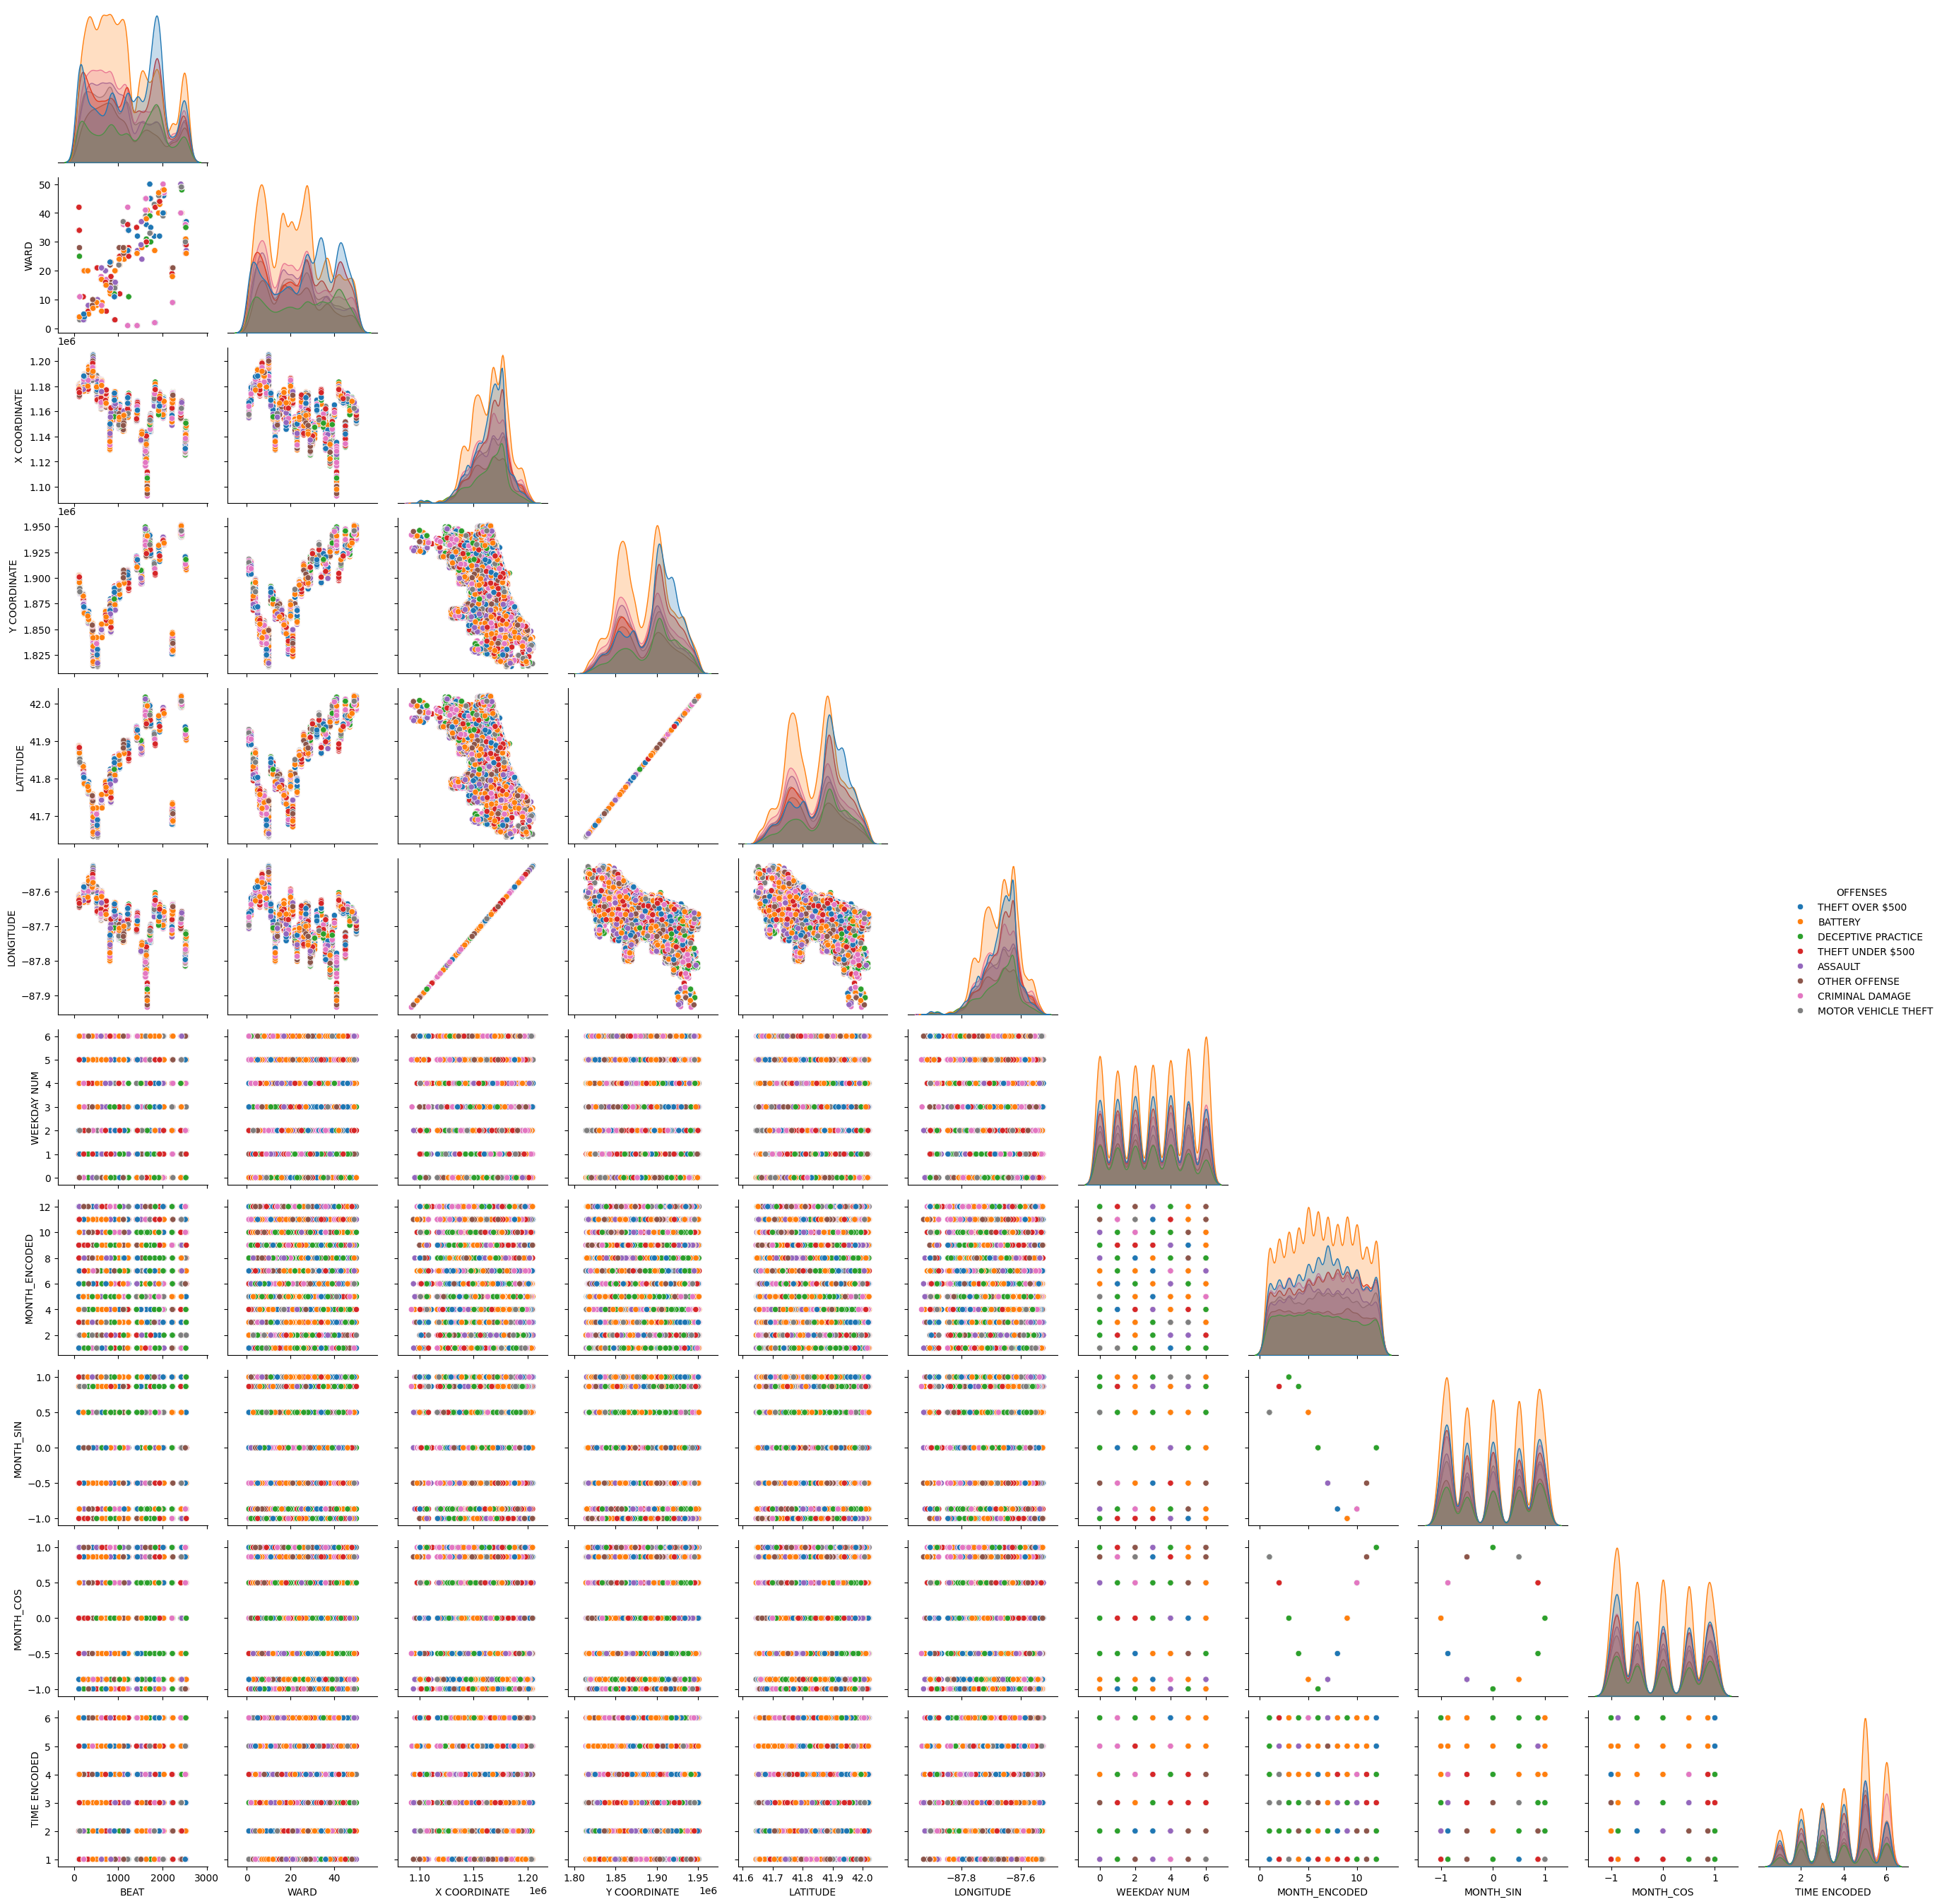

In [50]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.pairplot(df, hue='OFFENSES', corner=True)
plt.title('Pairwise Relationship: Features and Target')
plt.show()
